# MLP on MNIST + Position Shift

You can open this notebook either within a supported container or Google colaboratory [here](https://colab.research.google.com/github/slaclab/slacml-school/blob/master/IntroNN/Pytorch-04-MNIST-Shifted-Solution.ipynb).

This notebook is similar to the previous notebooks where we applied MLP/CNN on MNIST dataset. What's new is that we look into how MLP performs when the digit's position is shifted (in both vertical and horizontal direction).

## Goal
1. Prepare MNIST dataset with position shift.
2. Train MLP and CNN on MNIST digit images without a shift. 
3. Run the inference on the test dataset with translational shift. 
4. Try two more combinations of (train,test) = (shifted,shifted) and (shifted,no shift).

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.figsize'] = [8, 6]
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.grid'] = True

import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.device(device)
import numpy as np
SEED=12345
_=np.random.seed(SEED)
_=torch.manual_seed(SEED)

### Note: `utils.py` module
For this notebook, `utils.py` is prepared with handy functions. We will go over those functions briefly (+in details if requested!) but they are helpers and do not concern the core contents of programming ML components.

## 1. Prepare dataset

Let's load MNIST dataset. You might have noticed that the MNIST dataset constructor can take a `transform` argument, which can be a composite of functions to be run upon preparing a dataset. This is handy: we already used a function to convert, automatically, image data into Pytorch tensor using `transforms.ToTensor()`. This time we also add what's called `utils.ImagePadder` that pads the MNIST 28x28 pixels images +N pixels in all ways (so it's (28+N)x(28+N) pixels). The constructor of `utils.ImagePadder` takes a boolean flag called `randomize` which then shifts the location of a digit within the padded image space.

We prepare dataset and dataloader for both train and test samples.

In [2]:
from torchvision import datasets, transforms
from utils import ImagePadder
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Prepare train data
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                               transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
# Prepare test data
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([ImagePadder(randomize=True),transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist-data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist-data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist-data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist-data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist-data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist-data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist-data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist-data/MNIST/raw



### Exercise 1

Play with the dataset and figure out how many pixels we have padded (i.e. what's the image size?).

In [3]:
print(test_dataset[0][0].shape)

torch.Size([1, 48, 48])


### Visualizing data

I prepared another function that can visualize a list of classes and image. Let's visualize both train and test dataset. You should not see a shift for the train dataset, but the test dataset should show shifted locations.

Train dataset


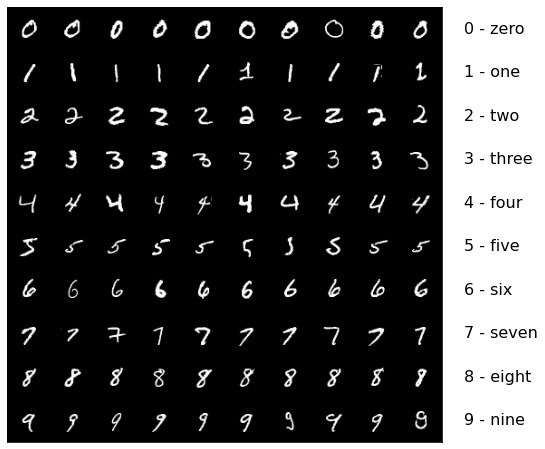

Test dataset


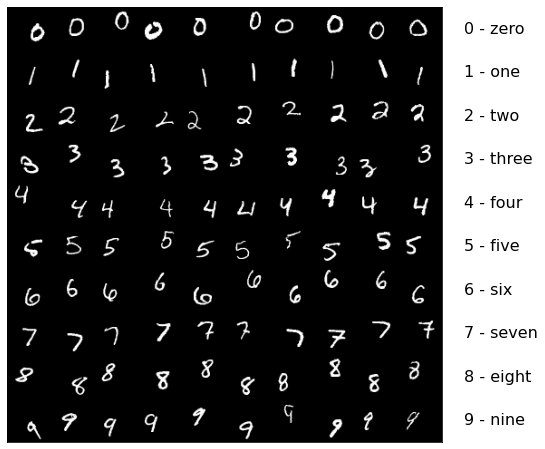

In [4]:
# Visualize classes
from utils import plot_dataset
print('Train dataset')
plot_dataset(train_dataset)
print('Test dataset')
plot_dataset(test_dataset)

<a href="network"></a>
## 2. Train MLP and CNN on MNIST with no shift

Let's define MLP and MNIST and train!

### Exercise 2
Design MLP and CNN the same way we did in the last notebook. Yes, that means you can _pretty much_ copy and paste, or you can practice trying to write from scratch :) I add a few required specifications below.

* The model's constructor should take 2 optional arguments with default values: `image_size=48` and `num_filters=`16`.
* MLP should have 2 `torch.nn.Linear` layers with `torch.nn.LeakyReLU` in between.
* CNN should have 3 `torch.nn.Conv2d` layers followed by `torch.nn.LeakyReLU` and `torch.nn.MaxPool2d`
  * Use the kernel size of 3 and stride 1 for the convolution layers
  * Use the kernel size of 2 and stride 2 for pooling layers
  * The number of filters in the first convolution layer should be `num_filters`, then it should increase by a factor of 2 each time.

In [5]:
class MLP(torch.nn.Module):
    def __init__(self, image_size=48, num_filters=16):
        
        super(MLP, self).__init__()
        # MLP w/ 2 hidden layers, 128 neurons each
        self._classifier = torch.nn.Sequential(
            torch.nn.Linear(image_size**2, num_filters), 
            torch.nn.LeakyReLU(),
            torch.nn.Linear(num_filters,10)
        )

    def forward(self, x):
        # Make 2d image into 1D array
        x_1d = x.view(-1, np.prod(x.size()[1:]))
        return self._classifier(x_1d)

class CNN(torch.nn.Module):
    def __init__(self, image_size=48, num_filters=16):
        
        super(CNN, self).__init__()
        # feature extractor CNN
        self._feature_extractor = torch.nn.Sequential(
            torch.nn.Conv2d(1,num_filters,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters,num_filters*2,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(2,2),
            torch.nn.Conv2d(num_filters*2,num_filters*4,3,padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(image_size//4,image_size//4)
        )
        # classifier MLP
        self._classifier = torch.nn.Linear(num_filters*4,10)

    def forward(self, x):
        # extract features
        features = self._feature_extractor(x)
        # flatten the 3d tensor (2d space x channels = features)
        features = features.view(-1, np.prod(features.size()[1:]))
        # classify and return
        return self._classifier(features)

Next, let's define a training and testing loop. We re-use the code we wrote in the previous hands-on session. 

In [6]:
from ipywidgets import IntProgress
from IPython.display import display
from torch.utils.tensorboard import SummaryWriter
import time

def run_train(model, loader,  
              num_iterations=100, log_dir='log',
              lr=0.001, optimizer='SGD', device=None):
    print("\nTraining...")
    tstart = time.time()
    if log_dir:
        writer = SummaryWriter(log_dir=log_dir)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = getattr(torch.optim,optimizer)(model.parameters(),lr=lr)
    f = IntProgress(min=0,max=int(num_iterations/100),bar_style='info')
    display(f)
    
    iteration = 0
    while iteration < num_iterations:
        for data,label in loader:
            
            if device:
                data,label = data.to(device),label.to(device)

            loss = criterion(model(data), label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if log_dir: 
                writer.add_scalar('loss/train', loss.item(), iteration)
            if iteration%100 == 0:
                f.value += 1
            # Brake if we consumed all iteration counts
            iteration += 1
            if iteration >= num_iterations:
                break
    print('done',time.time()-tstart,'[s]')


def run_test(model,loader,device=None):

    label_v, softmax_v = [],[]
    softmax = torch.nn.Softmax(dim=1)
    f = IntProgress(min=0,max=int(len(loader)),bar_style='info')
    display(f)
    
    with torch.set_grad_enabled(False):
        for data,label in loader:
            if device:
                data,label = data.to(device), label.to(device)
            label_v.append  ( label.detach().reshape(-1)   )
            softmax_v.append( softmax(model(data)).detach())
            f.value += 1
    return torch.concat(label_v).cpu().numpy(), torch.concat(softmax_v).cpu().numpy()


### Exercise 3

* Train MLP and CNN
* Compare the loss curve

In [7]:
mlp = MLP(image_size=48,num_filters=32).cuda()

run_train(mlp, train_loader, 4000, log_dir='tmnist_cnn/mlp_shift_no', optimizer='Adam', device=device)

cnn = CNN(image_size=48).cuda()

run_train(cnn, train_loader, 4000, log_dir='tmnist_cnn/cnn_shift_no', optimizer='Adam', device=device)


Training...


IntProgress(value=0, bar_style='info', max=40)

done 10.725740194320679 [s]

Training...


IntProgress(value=0, bar_style='info', max=40)

done 16.1203670501709 [s]


In [8]:
%load_ext tensorboard

%tensorboard --logdir tmnist_cnn

## 3. Run the inference using the test dataset with a position shift

Let's run the inference and print out the accuracy on the total test dataset.

In [9]:

# MLP
label, softmax = run_test(mlp,test_loader,device=device)

print('MLP accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))

result_mlp = dict(label=label, softmax=softmax)

# CNN
label, softmax = run_test(cnn,test_loader,device=device)

print('CNN accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))

result_cnn = dict(label=label, softmax=softmax)

IntProgress(value=0, bar_style='info', max=313)

MLP accuracy 0.1307


IntProgress(value=0, bar_style='info', max=313)

CNN accuracy 0.9657


_Viola_! You can see CNN seems to work well, not too far from how it worked on 28x28 original MNIST images without a shift. On the other hand, MLP performs very poorly, only slightly better than a completely random guess (which would have been 0.1). Hopefully this demonstrated the feature of CNN which can learn translation invariant features.

### Correlation among classification target types
Without going details in how, I prepared 2 functions:

* `plot_softmax` shows the correlation of softmax score across different digits for each image. You see a decagon with digit types on each edge with lots of dots inside. Each dot represent the softmax score of one image. The location of a dot is determined by interpreting the softmax score as a position vector from the origin. If the score is completley uncertain (i.e. 0.1 for each type), this would put a point in the middle. If it is 100% a certain digit type, the dot will be on the correponding edge of the decagon.

* `plot_confusion_matrix` creates a classification output matrix that shows the true label type v.s. predicted type with the number of images filling the matrix cells.

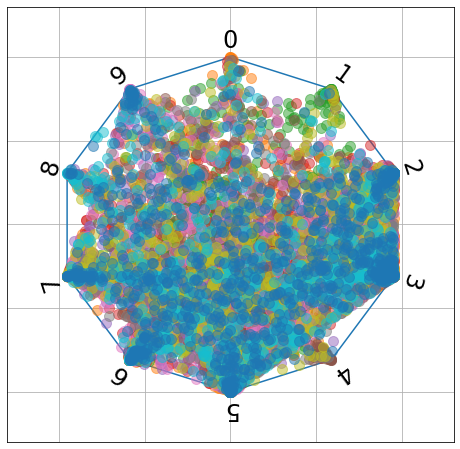

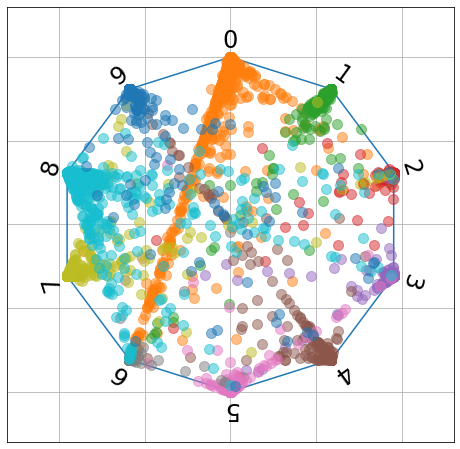

In [10]:
from utils import plot_softmax

plot_softmax(result_mlp['label'], result_mlp['softmax'], np.arange(10))

plot_softmax(result_cnn['label'], result_cnn['softmax'], np.arange(10))


In [11]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(result_mlp['softmax'],axis=1),result_mlp['label'])

array([[ 47,  77,  20,  32,  55,  20,  14,  21,  25,  32],
       [  2, 111,   8,   5,   7,   1,   9,  16,   5,   6],
       [203,  47, 194, 158, 154, 169, 169, 213, 102, 146],
       [233, 136, 168, 223, 246, 134, 206, 159, 266, 274],
       [  5,  78,  15,  13,  85,  10,  22,  32,   6,  20],
       [186, 217, 207, 206, 174, 218, 223, 197, 206, 186],
       [ 94, 148, 135, 122,  71,  95,  91, 144, 138, 110],
       [131, 251, 211, 157, 131, 156, 154, 207, 106, 125],
       [ 40,  27,  29,  29,  44,  27,  28,  12,  70,  49],
       [ 39,  43,  45,  65,  15,  62,  42,  27,  50,  61]])

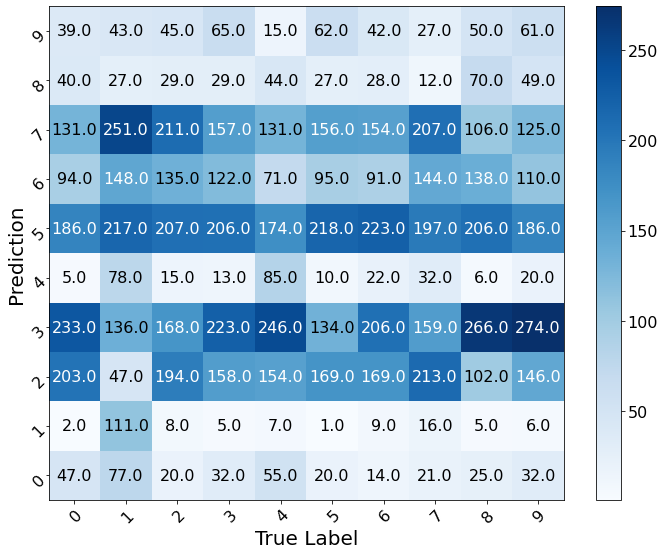

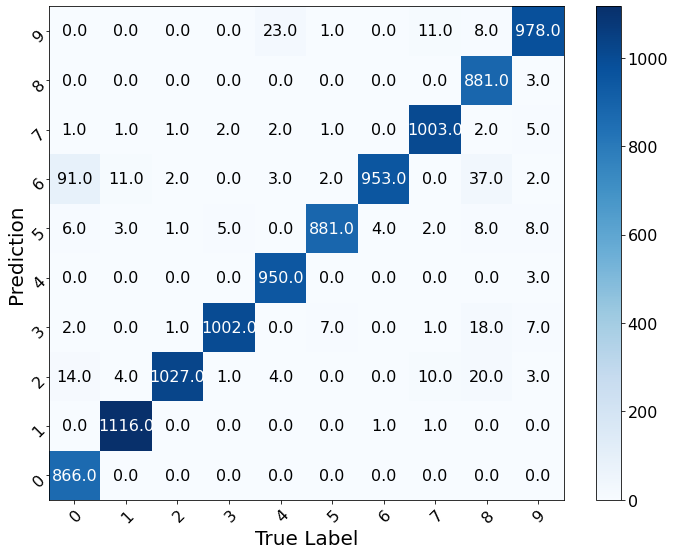

In [12]:
from utils import plot_confusion_matrix

plot_confusion_matrix(result_mlp['label'],
                      np.argmax(result_mlp['softmax'],axis=1),
                      np.arange(10))

plot_confusion_matrix(result_cnn['label'],
                      np.argmax(result_cnn['softmax'],axis=1),
                      np.arange(10))


## Exercise 4: repeat the study using (train,test) = (shifted,shifted)


In [13]:
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Prepare train data
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                               transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
# Prepare test data
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

# Define MLP
mlp = MLP(image_size=48,num_filters=32).cuda()
# Train MLP
run_train(mlp, train_loader, 4000, log_dir='tmnist_cnn/mlp_shift_yes', optimizer='Adam', device=device)

# Define CNN
cnn = CNN(image_size=48).cuda()
# Train CNN
run_train(cnn, train_loader, 4000, log_dir='tmnist_cnn/cnn_shift_yes', optimizer='Adam', device=device)

# Run the inference for MLP
label, softmax = run_test(mlp,test_loader,device=device)
print('MLP accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))
result_mlp = dict(label=label, softmax=softmax)

# Run the inference for CNN
label, softmax = run_test(cnn,test_loader,device=device)
print('CNN accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))
result_cnn = dict(label=label, softmax=softmax)


Training...


IntProgress(value=0, bar_style='info', max=40)

done 9.518168210983276 [s]

Training...


IntProgress(value=0, bar_style='info', max=40)

done 15.330624341964722 [s]


IntProgress(value=0, bar_style='info', max=313)

MLP accuracy 0.9474


IntProgress(value=0, bar_style='info', max=313)

CNN accuracy 0.9839


## Exercise 5: repeat the study using (train,test) = (shifted,no shift)


In [14]:
# Data file download directory
LOCAL_DATA_DIR = './mnist-data'
# Prepare train data
train_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=True, download=True,
                               transform=transforms.Compose([ImagePadder(randomize=True),transforms.ToTensor()]))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=True,num_workers=2,pin_memory=True)
# Prepare test data
test_dataset = datasets.MNIST(LOCAL_DATA_DIR, train=False, download=True,
                              transform=transforms.Compose([ImagePadder(randomize=False),transforms.ToTensor()]))
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=32,shuffle=False,num_workers=2,pin_memory=True)

# Define MLP
mlp = MLP(image_size=48,num_filters=32).cuda()
# Train MLP
run_train(mlp, train_loader, 4000, log_dir='tmnist_cnn/mlp_shift_yes2', optimizer='Adam', device=device)

# Define CNN
cnn = CNN(image_size=48).cuda()
# Train CNN
run_train(cnn, train_loader, 4000, log_dir='tmnist_cnn/cnn_shift_yes2', optimizer='Adam', device=device)

# Run the inference for MLP
label, softmax = run_test(mlp,test_loader,device=device)
print('MLP accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))
result_mlp = dict(label=label, softmax=softmax)

# Run the inference for CNN
label, softmax = run_test(cnn,test_loader,device=device)
print('CNN accuracy',(np.argmax(softmax,axis=1) == label).sum() / len(label))
result_cnn = dict(label=label, softmax=softmax)


Training...


IntProgress(value=0, bar_style='info', max=40)

done 9.949117660522461 [s]

Training...


IntProgress(value=0, bar_style='info', max=40)

done 16.15524435043335 [s]


IntProgress(value=0, bar_style='info', max=313)

MLP accuracy 0.7508


IntProgress(value=0, bar_style='info', max=313)

CNN accuracy 0.9805
